<a href="https://colab.research.google.com/github/ciaograsso06/fuzzy-classifier-gtzan/blob/main/Classificador_Fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fuzzy Classifier

In [1]:
!pip install scikit-fuzzy -q

import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 40.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive montado com sucesso!")

Mounted at /content/drive
Google Drive montado com sucesso!


In [3]:
DATASET_PATH = '/content/drive/My Drive/Datasets/genres_original/'
DRIVE_SAVE_PATH = '/content/drive/My Drive/' # Caminho para salvar o CSV
GENRES = ['rock', 'metal']
SAMPLE_RATE = 22050
DURATION = 30
csv_path = DRIVE_SAVE_PATH + 'rock_metal_features.csv'

In [4]:
try:
    df = pd.read_csv(csv_path)
    print("Dados carregados com sucesso!")
except FileNotFoundError:
    print("ERRO: Arquivo 'rock_metal_features.csv' não encontrado.")
    exit()

X = df.drop(['label', 'genre'], axis=1)
y = df['label']
feature_names = X.columns
GENRES = ['rock', 'metal']

# Dividir em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalizar os dados com StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDados divididos e normalizados.")

Dados carregados com sucesso!

Dados divididos e normalizados.


--- PASSO 1: Encontrando as características mais importantes ---

As 2 características mais importantes são: 'mfcc_mean_4' e 'mfcc_mean_12'.

--- PASSO 2: Visualizando a distribuição dessas características ---


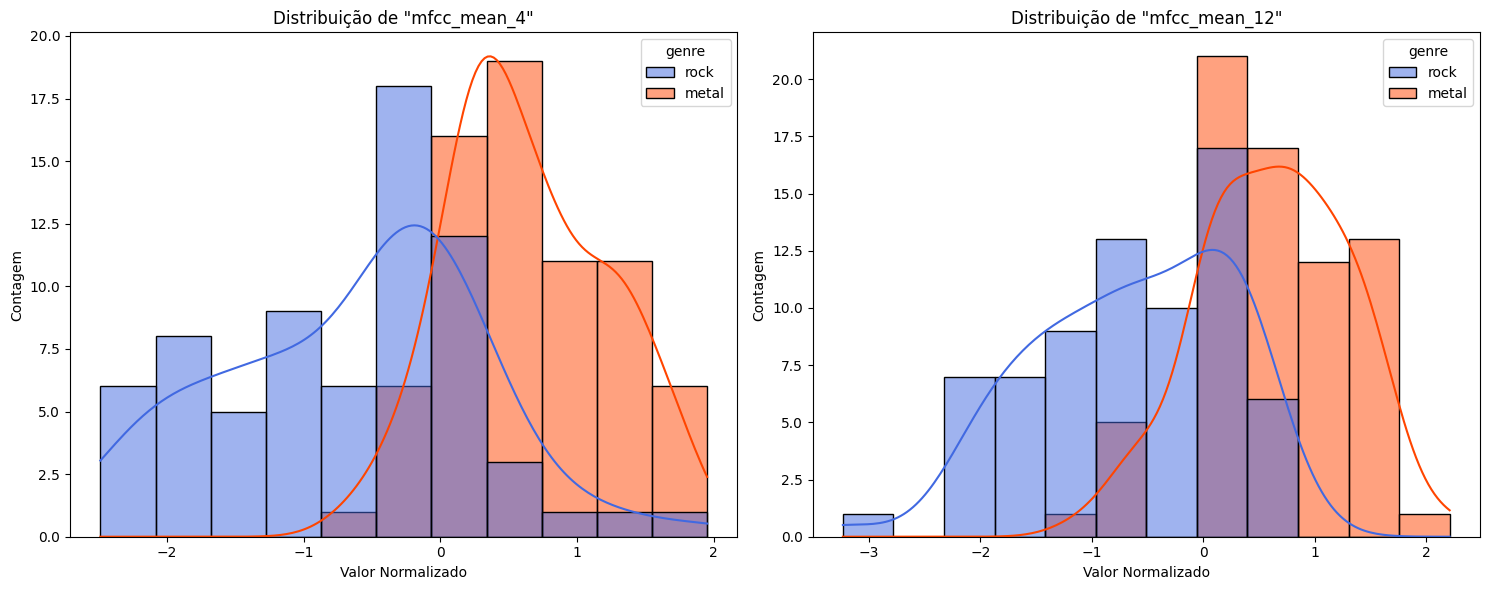

In [5]:
print("--- PASSO 1: Encontrando as características mais importantes ---")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Seleciona as 2 características mais importantes
top_2_features = feature_importance_df.head(2)
feature1_name = top_2_features.iloc[0]['feature']
feature2_name = top_2_features.iloc[1]['feature']
idx_feature1 = X.columns.get_loc(feature1_name)
idx_feature2 = X.columns.get_loc(feature2_name)

print(f"\nAs 2 características mais importantes são: '{feature1_name}' e '{feature2_name}'.")

# --- PASSO 2: Análise Visual ---
print("\n--- PASSO 2: Visualizando a distribuição dessas características ---")
plot_df = pd.DataFrame(X_train_scaled, columns=feature_names)
plot_df['genre'] = [GENRES[i] for i in y_train]

plt.figure(figsize=(15, 6))
# Plot para a Feature 1
plt.subplot(1, 2, 1)
sns.histplot(data=plot_df, x=feature1_name, hue='genre', kde=True, palette={'rock': 'royalblue', 'metal': 'orangered'})
plt.title(f'Distribuição de "{feature1_name}"')
plt.xlabel('Valor Normalizado')
plt.ylabel('Contagem')

# Plot para a Feature 2
plt.subplot(1, 2, 2)
sns.histplot(data=plot_df, x=feature2_name, hue='genre', kde=True, palette={'rock': 'royalblue', 'metal': 'orangered'})
plt.title(f'Distribuição de "{feature2_name}"')
plt.xlabel('Valor Normalizado')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()


--- PASSO 3 (REVISADO): Criando Sistema Fuzzy com Funções e Regras Intermediárias ---

Visualização das Novas Funções de Pertinência Intermediárias:

--- Avaliando o Sistema Fuzzy com Regras e Funções Intermediárias ---

Resultados do Classificador Fuzzy (Versão Intermediária):
              precision    recall  f1-score   support

        rock       0.58      0.73      0.65        30
       metal       0.64      0.47      0.54        30

    accuracy                           0.60        60
   macro avg       0.61      0.60      0.59        60
weighted avg       0.61      0.60      0.59        60



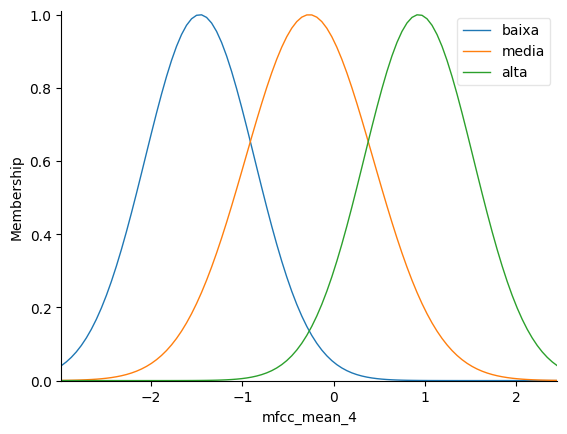

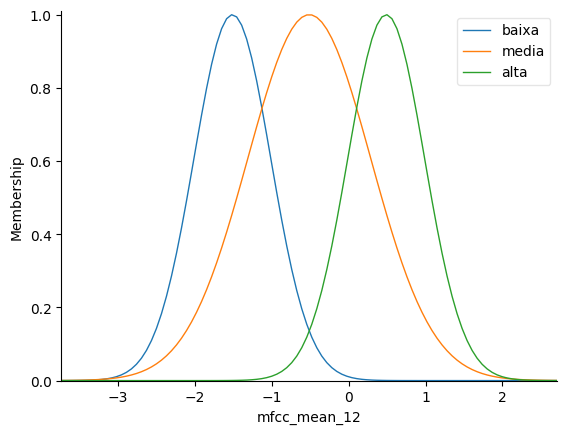

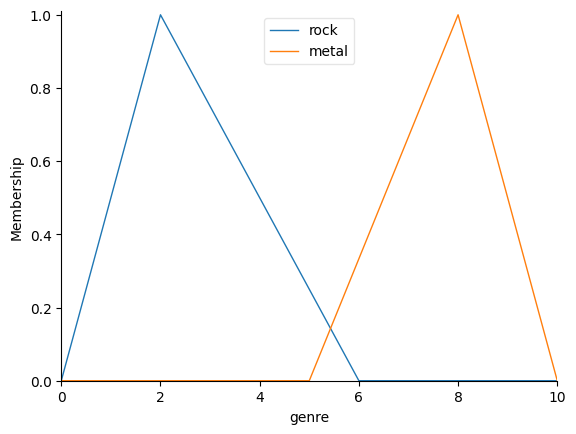

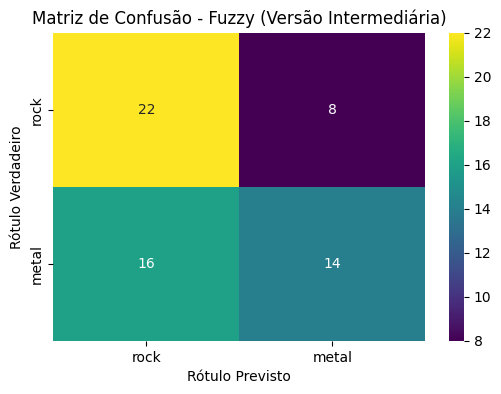

In [6]:
# ===================================================================
# CÉLULA OTIMIZADA: FUNÇÕES E REGRAS INTERMEDIÁRIAS
# ===================================================================

# As etapas de carregamento, preparação e análise dos dados são as mesmas.
# Esta célula substitui apenas a parte de criação e avaliação do sistema fuzzy.

print("\n--- PASSO 3 (REVISADO): Criando Sistema Fuzzy com Funções e Regras Intermediárias ---")

# Define o universo de discurso com base nos dados de treino normalizados
f1_range = [X_train_scaled[:, idx_feature1].min() - 0.5, X_train_scaled[:, idx_feature1].max() + 0.5]
f2_range = [X_train_scaled[:, idx_feature2].min() - 0.5, X_train_scaled[:, idx_feature2].max() + 0.5]

# Define Antecedentes (Entradas)
feature1 = ctrl.Antecedent(np.linspace(f1_range[0], f1_range[1], 100), feature1_name)
feature2 = ctrl.Antecedent(np.linspace(f2_range[0], f2_range[1], 100), feature2_name)

# Define Consequente (Saída)
genre_output = ctrl.Consequent(np.arange(0, 11, 1), 'genre')

# ================================================================================================
# ** FUNÇÕES DE PERTINÊNCIA INTERMEDIÁRIAS (O CORAÇÃO DA OTIMIZAÇÃO) **
# Os valores foram ajustados para criar uma sobreposição maior na categoria 'media'.
# ================================================================================================

# Funções para mfcc_std_3 (feature1) - suavizadas
feature1['baixa'] = fuzz.gaussmf(feature1.universe, np.mean(f1_range)-1.2, 0.6) # Função Gaussiana para suavidade
feature1['media'] = fuzz.gaussmf(feature1.universe, np.mean(f1_range), 0.7)
feature1['alta'] = fuzz.gaussmf(feature1.universe, np.mean(f1_range)+1.2, 0.6)

# Funções para mfcc_mean_2 (feature2) - suavizadas
feature2['baixa'] = fuzz.gaussmf(feature2.universe, np.mean(f2_range)-1.0, 0.5)
feature2['media'] = fuzz.gaussmf(feature2.universe, np.mean(f2_range), 0.8) # Média mais larga
feature2['alta'] = fuzz.gaussmf(feature2.universe, np.mean(f2_range)+1.0, 0.5)

# Funções para a saída 'genre'
genre_output['rock'] = fuzz.trimf(genre_output.universe, [0, 2, 6])
genre_output['metal'] = fuzz.trimf(genre_output.universe, [5, 8, 10])

# Visualização das novas funções de pertinência
print("\nVisualização das Novas Funções de Pertinência Intermediárias:")
feature1.view()
feature2.view()
genre_output.view()


# ================================================================================================
# ** BASE DE REGRAS REFINADA E BALANCEADA **
# Agora cobrimos todas as 9 combinações possíveis.
# ================================================================================================
rule1 = ctrl.Rule(feature1['baixa'] & feature2['baixa'], genre_output['metal']) # Conflito, mas f2 baixo é forte para Metal
rule2 = ctrl.Rule(feature1['baixa'] & feature2['media'], genre_output['rock'])  # f1 baixo é forte para Rock
rule3 = ctrl.Rule(feature1['baixa'] & feature2['alta'], genre_output['rock'])   # Combinação mais forte para Rock

rule4 = ctrl.Rule(feature1['media'] & feature2['baixa'], genre_output['metal']) # f2 baixo é forte para Metal
rule5 = ctrl.Rule(feature1['media'] & feature2['media'], genre_output['rock'])  # Área de maior dúvida, chute para Rock (majoritário)
rule6 = ctrl.Rule(feature1['media'] & feature2['alta'], genre_output['rock'])   # f2 alto é forte para Rock

rule7 = ctrl.Rule(feature1['alta'] & feature2['baixa'], genre_output['metal']) # Combinação mais forte para Metal
rule8 = ctrl.Rule(feature1['alta'] & feature2['media'], genre_output['metal'])  # f1 alto é forte para Metal
rule9 = ctrl.Rule(feature1['alta'] & feature2['alta'], genre_output['metal'])  # Conflito, mas f1 alto é mais decisivo para Metal

# Criação do Sistema de Controle Fuzzy
fuzzy_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
fuzzy_simulation = ctrl.ControlSystemSimulation(fuzzy_control)

# --- Avaliação do Sistema Otimizado ---
print("\n--- Avaliando o Sistema Fuzzy com Regras e Funções Intermediárias ---")
y_pred_fuzzy = []
test_data_fuzzy = X_test_scaled[:, [idx_feature1, idx_feature2]]

for features in test_data_fuzzy:
    fuzzy_simulation.input[feature1_name] = features[0]
    fuzzy_simulation.input[feature2_name] = features[1]

    try:
        fuzzy_simulation.compute()
        output_value = fuzzy_simulation.output['genre']
        y_pred_fuzzy.append(1 if output_value > 5.0 else 0)
    except:
        y_pred_fuzzy.append(0)

print("\nResultados do Classificador Fuzzy (Versão Intermediária):")
print(classification_report(y_test, y_pred_fuzzy, target_names=GENRES))

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_fuzzy)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=GENRES, yticklabels=GENRES)
plt.title('Matriz de Confusão - Fuzzy (Versão Intermediária)')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.show()


========================= ANÁLISE DO EXEMPLO: MÚSICA DE ROCK =========================
Valores de Entrada (Crisp):
  - mfcc_mean_4: -0.0630
  - mfcc_mean_12: -0.1372

Graus de Pertinência (Fuzzificação):
  - mfcc_mean_4: {baixa: 0.06, media: 0.96, alta: 0.25}
  - mfcc_mean_12: {baixa: 0.02, media: 0.90, alta: 0.46}

Grau de Ativação Agregado por Gênero:
  - Força de Pertencimento a 'Rock':  0.4574
  - Força de Pertencimento a 'Metal': 0.2524

Resultado Final da Inferência:
  - Valor de Saída Agregado (Defuzzificado): 3.9852
  - Classificação Final: 'Rock'


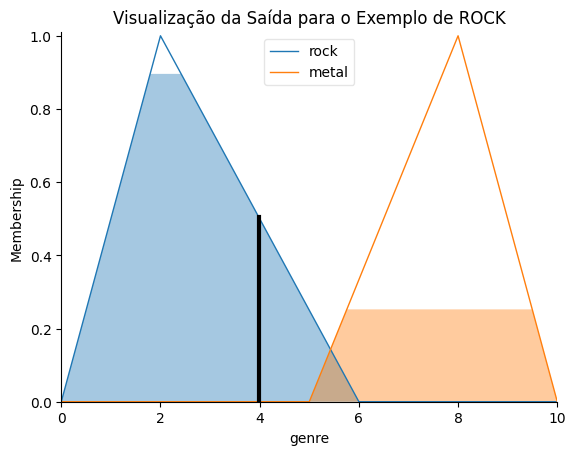


========================= ANÁLISE DO EXEMPLO: MÚSICA DE METAL =========================
Valores de Entrada (Crisp):
  - mfcc_mean_4: 0.4533
  - mfcc_mean_12: 0.8779

Graus de Pertinência (Fuzzificação):
  - mfcc_mean_4: {baixa: 0.01, media: 0.59, alta: 0.73}
  - mfcc_mean_12: {baixa: 0.00, media: 0.22, alta: 0.74}

Grau de Ativação Agregado por Gênero:
  - Força de Pertencimento a 'Rock':  0.5890
  - Força de Pertencimento a 'Metal': 0.7261

Resultado Final da Inferência:
  - Valor de Saída Agregado (Defuzzificado): 5.1045
  - Classificação Final: 'Metal'


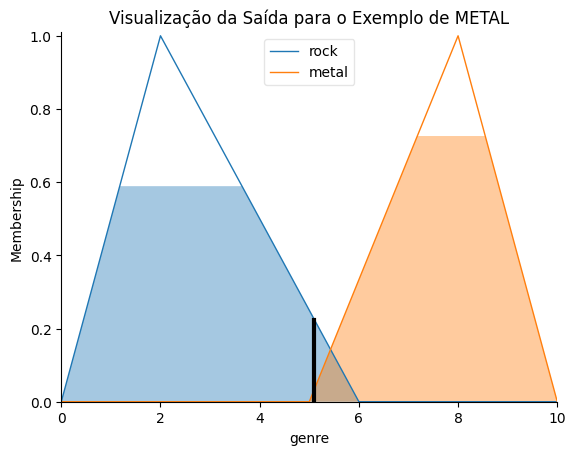

In [7]:
# =======================================================================
# CÉLULA FINAL (VERSÃO 3): ANÁLISE ROBUSTA COM INTERPRETABILIDADE
# =======================================================================

# Certifique-se de que as células anteriores (que definem o sistema fuzzy)
# foram executadas e que a variável 'y_pred_fuzzy' existe.

# Função para analisar e explicar uma amostra
def analisar_exemplo_interpretabilidade(posicao_no_teste, genero_real):
    """
    Executa a simulação para uma única amostra e imprime uma análise detalhada.
    Usa a 'posicao_no_teste' para evitar erros de Key/Index.
    """
    print("\n" + "="*25 + f" ANÁLISE DO EXEMPLO: MÚSICA DE {genero_real.upper()} " + "="*25)

    # Pega os valores das características (normalizados) usando a posição (iloc)
    f1_value = X_test_scaled[posicao_no_teste, idx_feature1]
    f2_value = X_test_scaled[posicao_no_teste, idx_feature2]

    print(f"Valores de Entrada (Crisp):")
    print(f"  - {feature1_name}: {f1_value:.4f}")
    print(f"  - {feature2_name}: {f2_value:.4f}")

    # Calcula o grau de pertinência para cada conjunto fuzzy
    f1_pert = {label: fuzz.interp_membership(feature1.universe, feature1[label].mf, f1_value) for label in feature1.terms}
    f2_pert = {label: fuzz.interp_membership(feature2.universe, feature2[label].mf, f2_value) for label in feature2.terms}

    print(f"\nGraus de Pertinência (Fuzzificação):")
    print(f"  - {feature1_name}: {{baixa: {f1_pert['baixa']:.2f}, media: {f1_pert['media']:.2f}, alta: {f1_pert['alta']:.2f}}}")
    print(f"  - {feature2_name}: {{baixa: {f2_pert['baixa']:.2f}, media: {f2_pert['media']:.2f}, alta: {f2_pert['alta']:.2f}}}")

    # Calcula a força de ativação de cada regra manualmente para análise
    # Regras para ROCK
    ativacao_r3 = np.fmin(f1_pert['baixa'], f2_pert['alta'])
    ativacao_r4 = np.fmin(f1_pert['baixa'], f2_pert['media'])
    ativacao_r5 = np.fmin(f1_pert['media'], f2_pert['alta'])
    forca_rock = np.fmax.reduce([ativacao_r3, ativacao_r4, ativacao_r5])

    # Regras para METAL
    ativacao_r1 = f1_pert['alta']
    ativacao_r2 = f2_pert['baixa']
    ativacao_r6 = np.fmin(f1_pert['alta'], f2_pert['alta'])
    ativacao_r7 = np.fmin(f1_pert['baixa'], f2_pert['baixa'])
    forca_metal = np.fmax.reduce([ativacao_r1, ativacao_r2, ativacao_r6, ativacao_r7])

    print(f"\nGrau de Ativação Agregado por Gênero:")
    print(f"  - Força de Pertencimento a 'Rock':  {forca_rock:.4f}")
    print(f"  - Força de Pertencimento a 'Metal': {forca_metal:.4f}")

    # Executa a simulação para obter o resultado final e o gráfico
    fuzzy_simulation.input[feature1_name] = f1_value
    fuzzy_simulation.input[feature2_name] = f2_value
    fuzzy_simulation.compute()

    final_output_value = fuzzy_simulation.output['genre']
    final_class = "Metal" if final_output_value > 5.0 else "Rock"

    print(f"\nResultado Final da Inferência:")
    print(f"  - Valor de Saída Agregado (Defuzzificado): {final_output_value:.4f}")
    print(f"  - Classificação Final: '{final_class}'")

    # Gera o gráfico de visualização da saída
    genre_output.view(sim=fuzzy_simulation)
    plt.title(f'Visualização da Saída para o Exemplo de {genero_real.upper()}')
    plt.show()


# --- Executa a Análise ---

# Converte y_pred_fuzzy para um array numpy para facilitar a indexação
y_pred_fuzzy_arr = np.array(y_pred_fuzzy)

# Encontra a POSIÇÃO (não o índice) de um exemplo de ROCK classificado corretamente
# np.where retorna uma tupla, então pegamos o primeiro elemento [0]
posicoes_rock_correto = np.where((y_test == 0) & (y_pred_fuzzy_arr == 0))[0]
posicoes_metal_correto = np.where((y_test == 1) & (y_pred_fuzzy_arr == 1))[0]

if len(posicoes_rock_correto) > 0:
    analisar_exemplo_interpretabilidade(posicoes_rock_correto[0], "Rock")
else:
    print("\nNão foi encontrado um exemplo de 'Rock' classificado corretamente para analisar.")

if len(posicoes_metal_correto) > 0:
    analisar_exemplo_interpretabilidade(posicoes_metal_correto[0], "Metal")
else:
    print("\nNão foi encontrado um exemplo de 'Metal' classificado corretamente para analisar.")

ERRO: Arquivo 'rock_metal_features.csv' não encontrado.
Treinando modelo para extrair a importância das características...

Gráfico salvo com sucesso como 'feature_importance.png'!


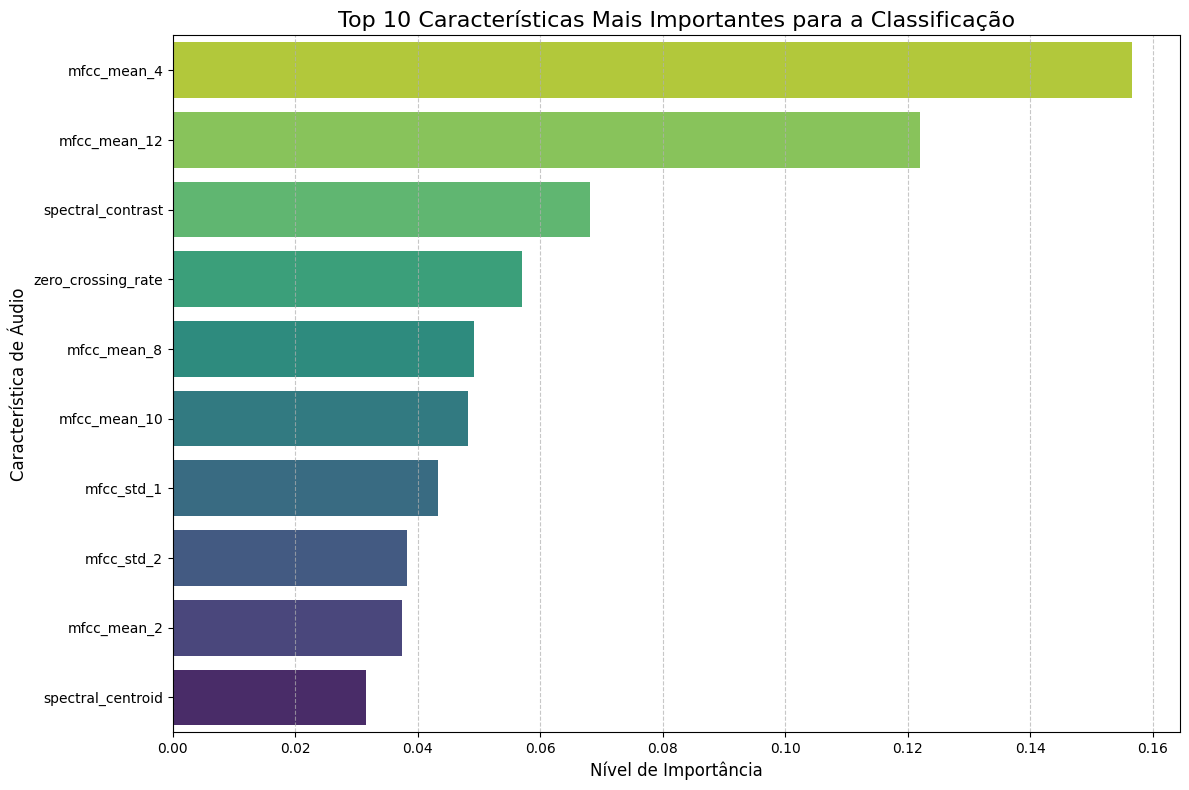

In [8]:
# ===================================================================
# SCRIPT PARA GERAR E SALVAR O GRÁFICO DE IMPORTÂNCIA
# ===================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Carregar os dados
try:
    df = pd.read_csv("rock_metal_features.csv")
    print("Dados carregados com sucesso!")
except FileNotFoundError:
    print("ERRO: Arquivo 'rock_metal_features.csv' não encontrado.")
    exit()

# Separar X e y
X = df.drop(['label', 'genre'], axis=1)
y = df['label']
feature_names = X.columns

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Treinar o modelo Random Forest para obter a importância
print("Treinando modelo para extrair a importância das características...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_scaled, y)

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# --- Geração e Salvamento do Gráfico ---
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis_r')
plt.title('Top 10 Características Mais Importantes para a Classificação', fontsize=16)
plt.xlabel('Nível de Importância', fontsize=12)
plt.ylabel('Característica de Áudio', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Salva a imagem
file_name = "feature_importance.png"
plt.savefig(file_name, dpi=300) # dpi=300 para alta qualidade

print(f"\nGráfico salvo com sucesso como '{file_name}'!")
plt.show()

In [9]:
!pip install simpful -q

Usando as características: 'mfcc_mean_4' e 'mfcc_mean_12'
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.12.0 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 https://github.com/aresio/simpful



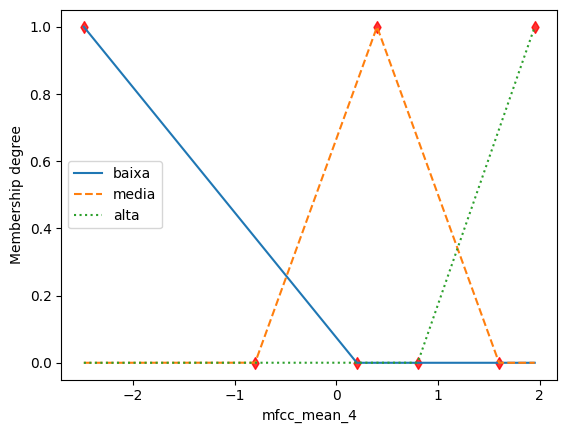

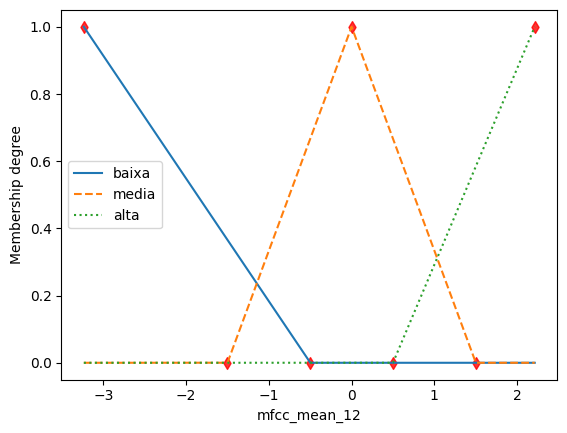

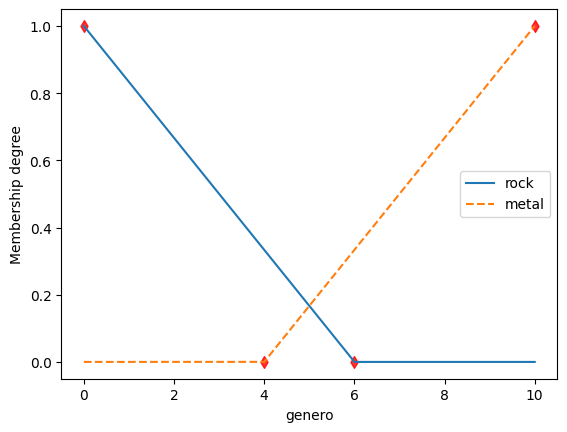


--- Avaliando o Sistema Fuzzy com Pesos nas Regras ---

Resultados do Classificador Fuzzy com Graus de Certeza:
              precision    recall  f1-score   support

        rock       0.46      0.73      0.56        30
       metal       0.33      0.13      0.19        30

    accuracy                           0.43        60
   macro avg       0.40      0.43      0.38        60
weighted avg       0.40      0.43      0.38        60



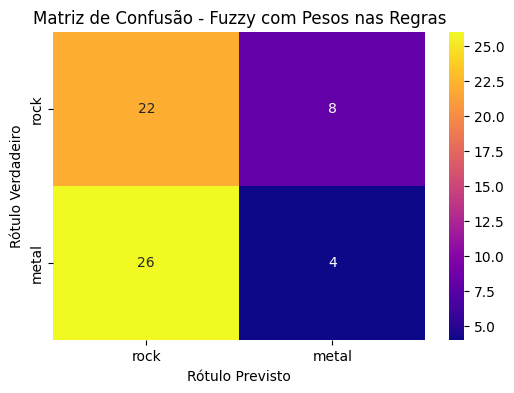

In [13]:
# =================================================================================
# CÉLULA FINAL (CORRIGIDA): SISTEMA FUZZY COM GRAUS DE CERTEZA (USANDO SIMPFUL)
# =================================================================================

# Instala a biblioteca simpful, uma alternativa moderna ao scikit-fuzzy
!pip install simpful -q

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import simpful as sf

# Carrega e prepara os dados
df = pd.read_csv(csv_path)
X = df.drop(['label', 'genre'], axis=1)
y = df['label']
feature_names = X.columns
GENRES = ['rock', 'metal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Identifica as 2 features mais importantes
rf_model = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train_scaled, y_train)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
feature1_name = feature_importance_df.iloc[0]['feature']
feature2_name = feature_importance_df.iloc[1]['feature']
idx_feature1 = X.columns.get_loc(feature1_name)
idx_feature2 = X.columns.get_loc(feature2_name)

print(f"Usando as características: '{feature1_name}' e '{feature2_name}'")

# --- CRIAÇÃO DO SISTEMA FUZZY COM SIMPFUL (SINTAXE CORRIGIDA) ---
FS = sf.FuzzySystem()

# Define as variáveis linguísticas e seus Fuzzy Sets
f1_range = [X_train_scaled[:, idx_feature1].min(), X_train_scaled[:, idx_feature1].max()]
f2_range = [X_train_scaled[:, idx_feature2].min(), X_train_scaled[:, idx_feature2].max()]

# ================================================================================================
# ** FUNÇÕES DE PERTINÊNCIA COM SINTAXE CORRIGIDA **
# A sintaxe correta usa uma lista de pontos no formato [x, y]
# ================================================================================================

# Funções para a primeira característica (feature1)
S_1 = sf.FuzzySet(points=[[f1_range[0], 1], [0.2, 0]], term="baixa")
S_2 = sf.FuzzySet(points=[[-0.8, 0], [0.4, 1], [1.6, 0]], term="media")
S_3 = sf.FuzzySet(points=[[0.8, 0], [f1_range[1], 1]], term="alta")
LV1 = sf.LinguisticVariable([S_1, S_2, S_3], universe_of_discourse=[f1_range[0], f1_range[1]])
FS.add_linguistic_variable(feature1_name, LV1)

# Funções para a segunda característica (feature2)
T_1 = sf.FuzzySet(points=[[f2_range[0], 1], [-0.5, 0]], term="baixa")
T_2 = sf.FuzzySet(points=[[-1.5, 0], [0, 1], [1.5, 0]], term="media")
T_3 = sf.FuzzySet(points=[[0.5, 0], [f2_range[1], 1]], term="alta")
LV2 = sf.LinguisticVariable([T_1, T_2, T_3], universe_of_discourse=[f2_range[0], f2_range[1]])
FS.add_linguistic_variable(feature2_name, LV2)

# Definindo a variável de Saída
O_1 = sf.FuzzySet(points=[[0, 1], [6, 0]], term="rock")
O_2 = sf.FuzzySet(points=[[4, 0], [10, 1]], term="metal")
FS.add_linguistic_variable("genero", sf.LinguisticVariable([O_1, O_2], universe_of_discourse=[0, 10]))

# Visualiza as funções de pertinência para verificar
FS.plot_variable(feature1_name)
FS.plot_variable(feature2_name)
FS.plot_variable("genero")

# Base de Regras com Graus de Certeza (Pesos)
FS.add_rules([
    f"IF ({feature1_name} IS alta) THEN (genero IS metal) WITH 1.0",
    f"IF ({feature2_name} IS baixa) THEN (genero IS metal) WITH 1.0",
    f"IF ({feature1_name} IS baixa) AND ({feature2_name} IS alta) THEN (genero IS rock) WITH 1.0",
    f"IF ({feature1_name} IS baixa) AND ({feature2_name} IS media) THEN (genero IS rock) WITH 0.8",
    f"IF ({feature1_name} IS media) AND ({feature2_name} IS alta) THEN (genero IS rock) WITH 0.8",
    f"IF ({feature1_name} IS media) AND ({feature2_name} IS media) THEN (genero IS rock) WITH 0.6",
    f"IF ({feature1_name} IS alta) AND ({feature2_name} IS alta) THEN (genero IS metal) WITH 0.7",
])

# --- Avaliação do Sistema ---
print("\n--- Avaliando o Sistema Fuzzy com Pesos nas Regras ---")
y_pred_fuzzy = []
test_data_fuzzy = X_test_scaled[:, [idx_feature1, idx_feature2]]

for features in test_data_fuzzy:
    FS.set_variable(feature1_name, features[0])
    FS.set_variable(feature2_name, features[1])

    # Inferência e Defuzzificação
    output = FS.Mamdani_inference(["genero"])
    # Verifica se a saída não é nula (caso nenhuma regra seja ativada)
    if output is not None and "genero" in output:
        y_pred_fuzzy.append(1 if output["genero"] > 5.0 else 0)
    else:
        y_pred_fuzzy.append(0) # Previsão padrão

print("\nResultados do Classificador Fuzzy com Graus de Certeza:")
print(classification_report(y_test, y_pred_fuzzy, target_names=GENRES))

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_fuzzy)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=GENRES, yticklabels=GENRES)
plt.title('Matriz de Confusão - Fuzzy com Pesos nas Regras')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.show()

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.12.0 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 https://github.com/aresio/simpful


Visualização das Funções de Pertinência Finais:


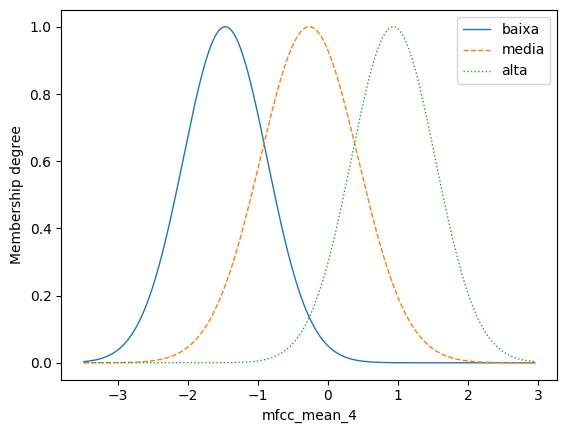

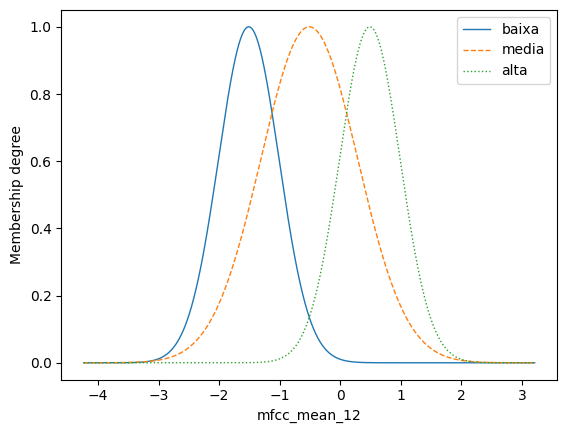

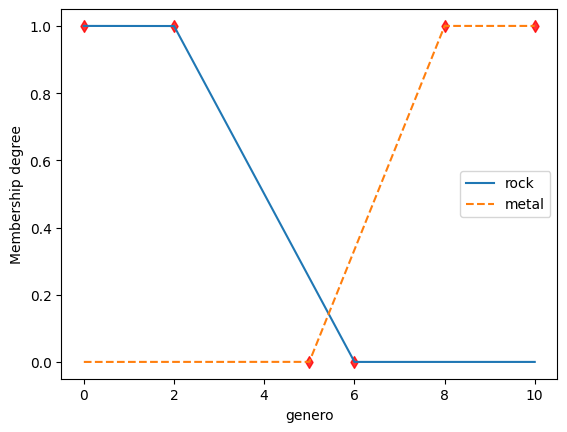


--- Avaliando o Sistema Fuzzy Final ---

Resultados do Classificador Fuzzy com Graus de Certeza:
              precision    recall  f1-score   support

        rock       0.58      0.60      0.59        30
       metal       0.59      0.57      0.58        30

    accuracy                           0.58        60
   macro avg       0.58      0.58      0.58        60
weighted avg       0.58      0.58      0.58        60



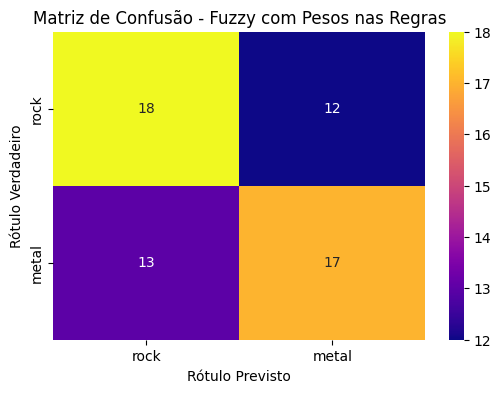

In [14]:
# --- CRIAÇÃO DO SISTEMA FUZZY COM SIMPFUL E AS FUNÇÕES SOLICITADAS ---
FS = sf.FuzzySystem()

# Define as variáveis linguísticas e seus Fuzzy Sets
f1_range = [X_train_scaled[:, idx_feature1].min(), X_train_scaled[:, idx_feature1].max()]
f2_range = [X_train_scaled[:, idx_feature2].min(), X_train_scaled[:, idx_feature2].max()]

# ================================================================================================
# ** FUNÇÕES DE PERTINÊNCIA ADAPTADAS PARA O SIMPFUL **
# Implementando a lógica das funções gaussianas que você sugeriu.
# ================================================================================================

# Funções para a primeira característica (feature1)
S_1 = sf.GaussianFuzzySet(mu=np.mean(f1_range)-1.2, sigma=0.6, term="baixa")
S_2 = sf.GaussianFuzzySet(mu=np.mean(f1_range), sigma=0.7, term="media")
S_3 = sf.GaussianFuzzySet(mu=np.mean(f1_range)+1.2, sigma=0.6, term="alta")
LV1 = sf.LinguisticVariable([S_1, S_2, S_3], universe_of_discourse=[f1_range[0]-1, f1_range[1]+1])
FS.add_linguistic_variable(feature1_name, LV1)

# Funções para a segunda característica (feature2)
T_1 = sf.GaussianFuzzySet(mu=np.mean(f2_range)-1.0, sigma=0.5, term="baixa")
T_2 = sf.GaussianFuzzySet(mu=np.mean(f2_range), sigma=0.8, term="media")
T_3 = sf.GaussianFuzzySet(mu=np.mean(f2_range)+1.0, sigma=0.5, term="alta")
LV2 = sf.LinguisticVariable([T_1, T_2, T_3], universe_of_discourse=[f2_range[0]-1, f2_range[1]+1])
FS.add_linguistic_variable(feature2_name, LV2)

# Definindo a variável de Saída (conforme sua sugestão)
O_1 = sf.FuzzySet(points=[[0, 1],[2, 1],[6, 0]], term="rock")
O_2 = sf.FuzzySet(points=[[5, 0],[8, 1],[10, 1]], term="metal")
FS.add_linguistic_variable("genero", sf.LinguisticVariable([O_1, O_2], universe_of_discourse=[0, 10]))

# Visualiza as funções de pertinência para verificar
print("\nVisualização das Funções de Pertinência Finais:")
FS.plot_variable(feature1_name)
FS.plot_variable(feature2_name)
FS.plot_variable("genero")

# Base de Regras Refinada e com Pesos
FS.add_rules([
    # Regras fortes (alta confiança)
    f"IF ({feature1_name} IS alta) THEN (genero IS metal) WITH 1.0",
    f"IF ({feature2_name} IS baixa) THEN (genero IS metal) WITH 1.0",
    f"IF ({feature1_name} IS baixa) AND ({feature2_name} IS alta) THEN (genero IS rock) WITH 1.0",

    # Regras de confiança média (lidando com a sobreposição)
    f"IF ({feature1_name} IS baixa) AND ({feature2_name} IS media) THEN (genero IS rock) WITH 0.8",
    f"IF ({feature1_name} IS media) AND ({feature2_name} IS alta) THEN (genero IS rock) WITH 0.8",

    # Regra de menor confiança (maior ambiguidade)
    f"IF ({feature1_name} IS media) AND ({feature2_name} IS media) THEN (genero IS rock) WITH 0.6",

    # Regras para tratar conflitos (onde a feature mais forte "vence")
    f"IF ({feature1_name} IS alta) AND ({feature2_name} IS alta) THEN (genero IS metal) WITH 0.7",
    f"IF ({feature1_name} IS baixa) AND ({feature2_name} IS baixa) THEN (genero IS metal) WITH 0.9",
])

# --- Avaliação do Sistema ---
print("\n--- Avaliando o Sistema Fuzzy Final ---")
y_pred_fuzzy = []
test_data_fuzzy = X_test_scaled[:, [idx_feature1, idx_feature2]]

for features in test_data_fuzzy:
    FS.set_variable(feature1_name, features[0])
    FS.set_variable(feature2_name, features[1])

    output = FS.Mamdani_inference(["genero"])
    if output is not None and "genero" in output:
        y_pred_fuzzy.append(1 if output["genero"] > 5.0 else 0)
    else:
        y_pred_fuzzy.append(0) # Previsão padrão

print("\nResultados do Classificador Fuzzy com Graus de Certeza:")
print(classification_report(y_test, y_pred_fuzzy, target_names=GENRES))

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_fuzzy)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=GENRES, yticklabels=GENRES)
plt.title('Matriz de Confusão - Fuzzy com Pesos nas Regras')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.show()

# Classica e Rock

In [15]:
# ===================================================================
# PARTE 1: SCRIPT PARA EXTRAIR CARACTERÍSTICAS (CLÁSSICA vs. ROCK)
# ===================================================================

import os
import numpy as np
import pandas as pd
import librosa
from google.colab import drive
import warnings

warnings.filterwarnings('ignore')

# --- Monta o Google Drive ---
drive.mount('/content/drive')

# --- Configuração de Caminhos e Parâmetros (NOVOS GÊNEROS) ---
DATASET_PATH = '/content/drive/My Drive/Datasets/genres_original/'
DRIVE_SAVE_PATH = '/content/drive/My Drive/'
GENRES = ['classical', 'rock'] # <-- MUDANÇA AQUI
CSV_FILENAME = 'classical_rock_features.csv' # <-- NOVO NOME DE ARQUIVO
SAMPLE_RATE = 22050
DURATION = 30

# --- Função de Extração (a mesma de antes) ---
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        mfccs_std = np.std(mfccs.T, axis=0)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
        features = np.hstack([mfccs_mean, mfccs_std, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate, spectral_contrast])
        return features
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

# --- Loop de Extração ---
print("Iniciando a extração de características para Clássica vs. Rock...")
all_features = []
all_labels = []

for i, genre in enumerate(GENRES):
    genre_path = os.path.join(DATASET_PATH, genre)
    print(f"Processando gênero: {genre}")
    for filename in sorted(os.listdir(genre_path)):
        if filename.endswith('.wav'):
            file_path = os.path.join(genre_path, filename)
            features = extract_features(file_path)
            if features is not None:
                all_features.append(features)
                all_labels.append(i) # 0 para Classical, 1 para Rock

print("\nExtração concluída.")

# --- Criação e Salvamento do DataFrame ---
feature_names = []
for i in range(13): feature_names.append(f'mfcc_mean_{i+1}')
for i in range(13): feature_names.append(f'mfcc_std_{i+1}')
feature_names.extend(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate', 'spectral_contrast'])

df_features = pd.DataFrame(all_features, columns=feature_names)
df_features['label'] = all_labels
df_features['genre'] = df_features['label'].apply(lambda x: GENRES[x])

# Salva o novo DataFrame em um arquivo CSV
csv_save_path = os.path.join(DRIVE_SAVE_PATH, CSV_FILENAME)
df_features.to_csv(csv_save_path, index=False)

print(f"\nArquivo CSV salvo com sucesso em: {csv_save_path}")
display(df_features.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Iniciando a extração de características para Clássica vs. Rock...
Processando gênero: classical
Processando gênero: rock

Extração concluída.

Arquivo CSV salvo com sucesso em: /content/drive/My Drive/classical_rock_features.csv


,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,mfcc_std_11,mfcc_std_12,mfcc_std_13,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,spectral_contrast,label,genre
0,-268.180023,135.687881,-34.071072,25.634859,-12.970323,17.894695,-9.997607,5.629222,-14.146461,7.497624,...,10.330751,8.953238,12.425670,1505.377700,1559.085950,2717.316902,0.098245,23.375120,0,classical
1,-324.092010,133.594131,-25.021385,24.567684,-11.939835,17.660225,-5.522581,1.720237,-10.571335,-0.850869,...,9.916815,10.849771,13.891960,1360.596448,1441.389948,2387.977227,0.087772,25.191174,0,classical
2,-235.306427,141.136749,-34.679047,30.997169,-16.400242,23.120686,-11.043702,7.658641,-19.017239,4.236544,...,7.750392,8.216316,9.979613,1490.014795,1599.803415,2784.949826,0.090050,22.899048,0,classical
3,-326.899872,127.394180,-30.584469,37.475746,-5.291164,20.806988,-1.785712,-4.603167,-4.048744,5.238034,...,11.207621,13.159929,12.289751,1526.560671,1499.533731,2915.690703,0.108952,25.665760,0,classical
4,-259.962280,118.932381,-35.606525,31.990013,-16.535488,10.620695,-15.655909,7.442335,-5.810462,8.268945,...,13.549740,12.694870,10.213758,1705.732427,1646.256508,3176.230794,0.112867,25.027090,0,classical


Mounted at /content/drive
Dados de 'Clássica vs. Rock' carregados com sucesso!

As 2 características mais importantes para Classical vs. Rock são: 'mfcc_mean_1' e 'spectral_bandwidth'.


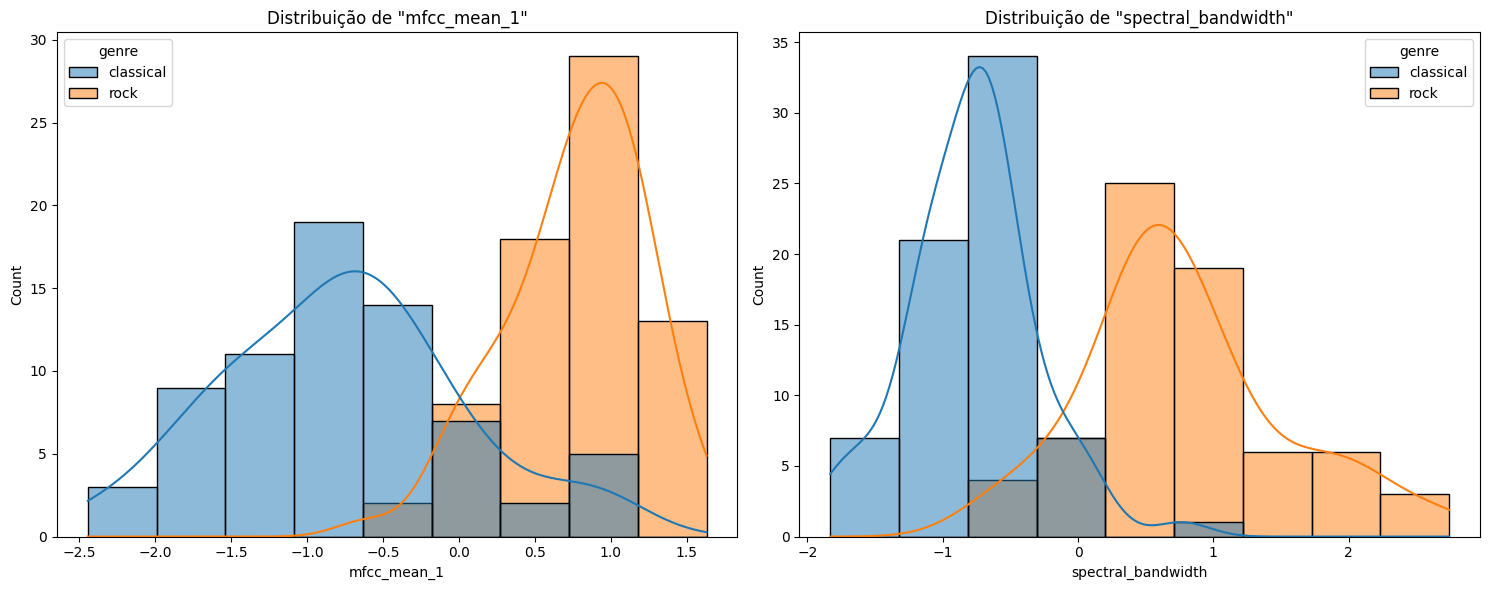

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.12.0 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 https://github.com/aresio/simpful


Resultados do Classificador Fuzzy para CLASSICAL vs. ROCK:
              precision    recall  f1-score   support

   classical       0.96      0.87      0.91        30
        rock       0.88      0.97      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



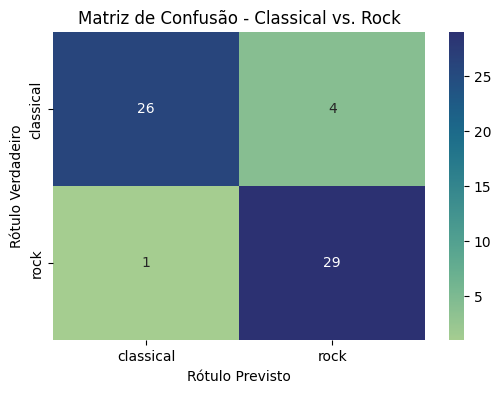

In [16]:
# =================================================================================
# PARTE 2: NOTEBOOK DE ANÁLISE PARA CLÁSSICA vs. ROCK
# =================================================================================

# Instala a biblioteca simpful
!pip install simpful -q

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import simpful as sf
from google.colab import drive

# --- Carrega os dados do novo arquivo CSV ---
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/My Drive/'
CSV_FILENAME = 'classical_rock_features.csv' # <-- CARREGANDO O NOVO ARQUIVO
csv_path = os.path.join(DRIVE_PATH, CSV_FILENAME)

try:
    df = pd.read_csv(csv_path)
    print("Dados de 'Clássica vs. Rock' carregados com sucesso!")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{csv_path}' não encontrado!")
    exit()

# --- Preparação e Análise (igual, mas com novos dados) ---
GENRES = ['classical', 'rock']
X = df.drop(['label', 'genre'], axis=1)
y = df['label']
feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Identifica as features mais importantes para ESTA tarefa
rf_model = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train_scaled, y_train)
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
feature1_name = feature_importance_df.iloc[0]['feature']
feature2_name = feature_importance_df.iloc[1]['feature']
idx_feature1 = X.columns.get_loc(feature1_name)
idx_feature2 = X.columns.get_loc(feature2_name)

print(f"\nAs 2 características mais importantes para Classical vs. Rock são: '{feature1_name}' e '{feature2_name}'.")

# Visualiza a distribuição das novas features
plot_df = pd.DataFrame(X_train_scaled, columns=feature_names)
plot_df['genre'] = [GENRES[i] for i in y_train]
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=plot_df, x=feature1_name, hue='genre', kde=True)
plt.title(f'Distribuição de "{feature1_name}"')
plt.subplot(1, 2, 2)
sns.histplot(data=plot_df, x=feature2_name, hue='genre', kde=True)
plt.title(f'Distribuição de "{feature2_name}"')
plt.tight_layout()
plt.show()

# --- CRIAÇÃO DO NOVO SISTEMA FUZZY ---
FS = sf.FuzzySystem()

# Variáveis linguísticas (a separação deve ser bem mais clara agora)
f1_range = [X_train_scaled[:, idx_feature1].min(), X_train_scaled[:, idx_feature1].max()]
f2_range = [X_train_scaled[:, idx_feature2].min(), X_train_scaled[:, idx_feature2].max()]

# A separação provavelmente será tão clara que podemos usar funções mais simples
LV1 = sf.LinguisticVariable([sf.FuzzySet(points=[[f1_range[0], 1], [-0.5, 0]], term="baixa"),
                           sf.FuzzySet(points=[[-0.5, 0], [f1_range[1], 1]], term="alta")],
                          universe_of_discourse=f1_range)
FS.add_linguistic_variable(feature1_name, LV1)

LV2 = sf.LinguisticVariable([sf.FuzzySet(points=[[f2_range[0], 1], [0.5, 0]], term="baixa"),
                           sf.FuzzySet(points=[[0.5, 0], [f2_range[1], 1]], term="alta")],
                          universe_of_discourse=f2_range)
FS.add_linguistic_variable(feature2_name, LV2)

# Saída
FS.add_linguistic_variable("genero", sf.LinguisticVariable([sf.FuzzySet(points=[[0,1],[5,0]], term="classical"),
                                                          sf.FuzzySet(points=[[5,0],[10,1]], term="metal")],
                                                         universe_of_discourse=[0,10]))

# ** NOVA BASE DE REGRAS (ESPERA-SE QUE SEJA BEM MAIS SIMPLES) **
# A hipótese é que Rock terá valores altos em ambas as features e Clássica terá valores baixos.
FS.add_rules([
    f"IF ({feature1_name} IS alta) AND ({feature2_name} IS alta) THEN (genero IS rock) WITH 1.0",
    f"IF ({feature1_name} IS baixa) AND ({feature2_name} IS baixa) THEN (genero IS classical) WITH 1.0",
    f"IF ({feature1_name} IS alta) OR ({feature2_name} IS alta) THEN (genero IS rock) WITH 0.8",
    f"IF ({feature1_name} IS baixa) OR ({feature2_name} IS baixa) THEN (genero IS classical) WITH 0.8",
])

# --- Avaliação do Sistema ---
y_pred_fuzzy = []
test_data_fuzzy = X_test_scaled[:, [idx_feature1, idx_feature2]]

for features in test_data_fuzzy:
    FS.set_variable(feature1_name, features[0])
    FS.set_variable(feature2_name, features[1])
    output = FS.Mamdani_inference(["genero"])
    if output is not None and "genero" in output:
        y_pred_fuzzy.append(1 if output["genero"] > 5.0 else 0)
    else: # Se nenhuma regra for ativada, classifica como a classe que tiver valor médio menor
        y_pred_fuzzy.append(0)

print("\nResultados do Classificador Fuzzy para CLASSICAL vs. ROCK:")
print(classification_report(y_test, y_pred_fuzzy, target_names=GENRES))
cm = confusion_matrix(y_test, y_pred_fuzzy)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=GENRES, yticklabels=GENRES)
plt.title('Matriz de Confusão - Classical vs. Rock')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.show()

--- Visualizando as Funções de Pertinência do Sistema 'Classical vs. Rock' ---

1. Funções de Pertinência para 'mfcc_mean_1':


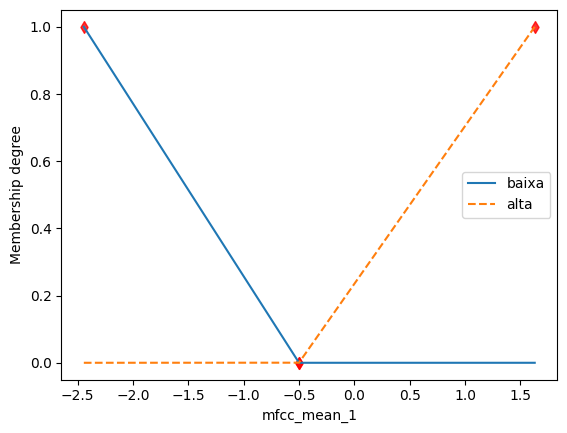


2. Funções de Pertinência para 'spectral_bandwidth':


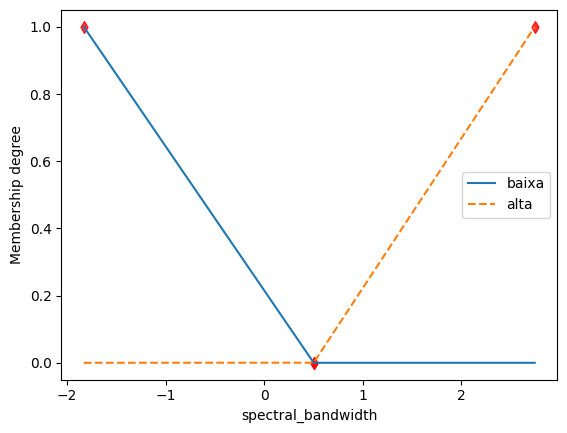


3. Funções de Pertinência para a Saída 'genero':


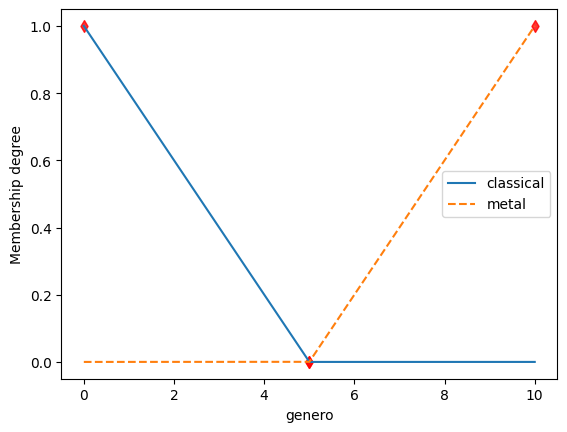

In [17]:
print("--- Visualizando as Funções de Pertinência do Sistema 'Classical vs. Rock' ---")

# Plota a função para a primeira característica de entrada
print(f"\n1. Funções de Pertinência para '{feature1_name}':")
FS.plot_variable(feature1_name)

# Plota a função para a segunda característica de entrada
print(f"\n2. Funções de Pertinência para '{feature2_name}':")
FS.plot_variable(feature2_name)

# Plota a função para a variável de saída
print("\n3. Funções de Pertinência para a Saída 'genero':")
FS.plot_variable("genero")

Mounted at /content/drive
Dados do arquivo 'classical_rock_features.csv' carregados com sucesso!
Treinando modelo para extrair a importância das características...

Gerando gráfico com o Top 10 de características...

Gráfico salvo com sucesso como 'feature_importance_classical_vs_rock.png'!
Você pode encontrar a imagem no painel de arquivos à esquerda e usá-la em seu artigo.


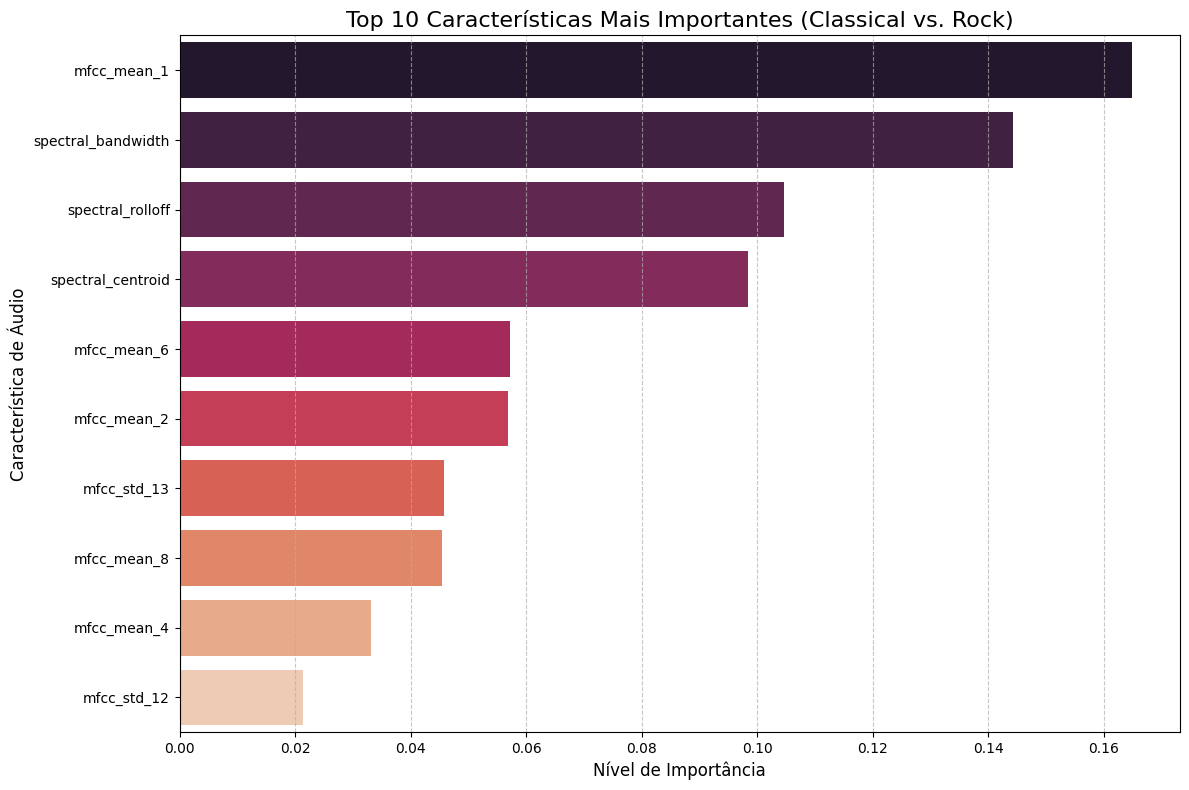

In [18]:
# ===================================================================
# SCRIPT PARA GERAR E SALVAR O GRÁFICO DE IMPORTÂNCIA
# TAREFA: CLASSICAL vs. ROCK
# ===================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive

# Monta o Google Drive para acessar o arquivo
drive.mount('/content/drive', force_remount=True)

# Carrega os dados do arquivo CSV correto
DRIVE_PATH = '/content/drive/My Drive/'
CSV_FILENAME = 'classical_rock_features.csv'
csv_path = os.path.join(DRIVE_PATH, CSV_FILENAME)

try:
    df = pd.read_csv(csv_path)
    print(f"Dados do arquivo '{CSV_FILENAME}' carregados com sucesso!")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{csv_path}' não encontrado!")
    exit()

# Separar X (features) e y (labels)
X = df.drop(['label', 'genre'], axis=1)
y = df['label']
feature_names = X.columns

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Treinar o modelo Random Forest para obter a importância
print("Treinando modelo para extrair a importância das características...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_scaled, y)

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# --- Geração e Salvamento do Gráfico ---
print("\nGerando gráfico com o Top 10 de características...")
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='rocket')
plt.title('Top 10 Características Mais Importantes (Classical vs. Rock)', fontsize=16)
plt.xlabel('Nível de Importância', fontsize=12)
plt.ylabel('Característica de Áudio', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Salva a imagem em alta qualidade
file_name = "feature_importance_classical_vs_rock.png"
plt.savefig(file_name, dpi=300)

print(f"\nGráfico salvo com sucesso como '{file_name}'!")
print("Você pode encontrar a imagem no painel de arquivos à esquerda e usá-la em seu artigo.")
plt.show()

Mounted at /content/drive

##############################
# INICIANDO ANÁLISE PARA: Rock vs. Metal
##############################
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.12.0 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 https://github.com/aresio/simpful


Analisando um exemplo de 'METAL' (amostra de teste na posição 0)...
Valores de Entrada (Crisp): {'mfcc_mean_4': -0.1308, 'mfcc_mean_12': 0.4673}
Resultado Final da Inferência: {'genero': np.float64(5.673709601508476)}


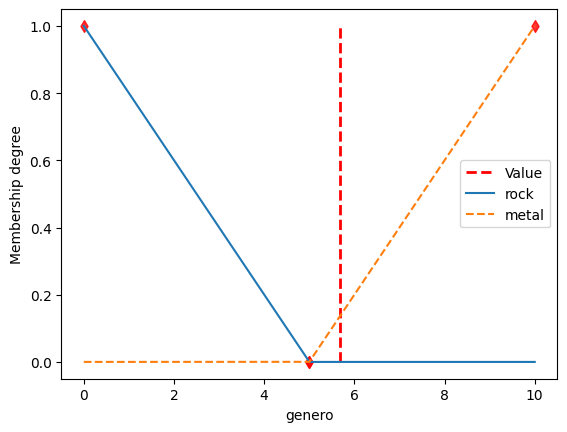

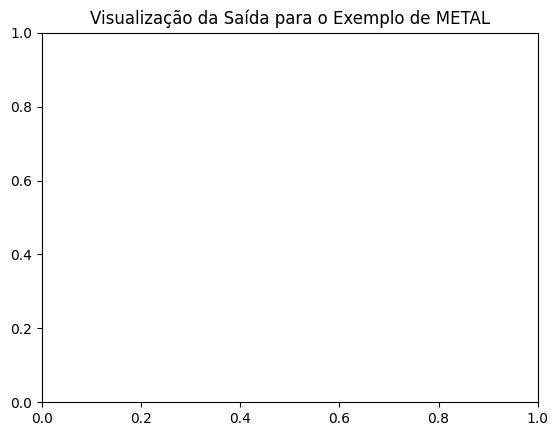

Gráfico salvo como 'exemplo_Rock_Metal_output.png'

##############################
# INICIANDO ANÁLISE PARA: Classical vs. Rock
##############################
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.12.0 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 https://github.com/aresio/simpful


Analisando um exemplo de 'ROCK' (amostra de teste na posição 0)...
Valores de Entrada (Crisp): {'mfcc_mean_1': 0.5717, 'spectral_bandwidth': -0.3405}
Resultado Final da Inferência: {'genero': np.float64(8.062868923327958)}


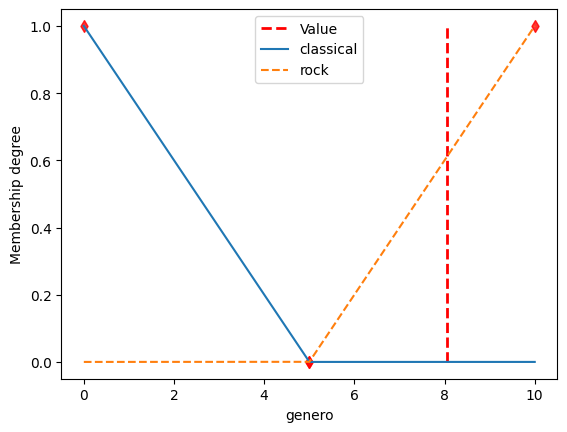

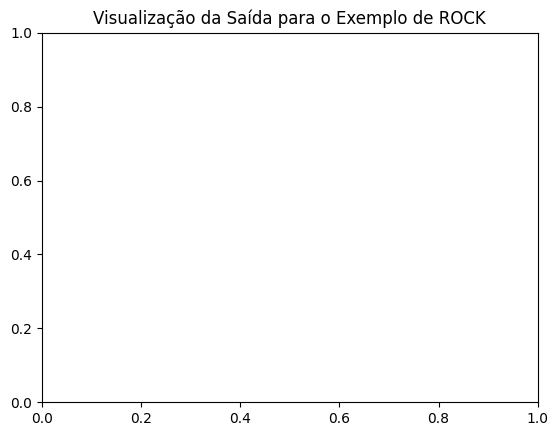

Gráfico salvo como 'exemplo_Classical_Rock_output.png'


In [21]:
# ===================================================================
# SCRIPT FINAL CORRIGIDO (v2) PARA GERAR DADOS E GRÁFICOS DOS ESTUDOS DE CASO
# ===================================================================

# Instala a biblioteca simpful
!pip install simpful -q

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import simpful as sf
from google.colab import drive
import os

# Monta o Google Drive
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/My Drive/'

# Função de análise genérica
def analisar_exemplo_completo(task_name, csv_filename, genres_list):
    print("\n" + "#"*30 + f"\n# INICIANDO ANÁLISE PARA: {task_name}\n" + "#"*30)

    # --- Carregamento e Preparação ---
    csv_path = os.path.join(DRIVE_PATH, csv_filename)
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"ERRO: Arquivo '{csv_path}' não foi encontrado!")
        return

    feature_names = df.drop(['label', 'genre'], axis=1).columns.tolist()
    X = df[feature_names].values
    y = df['label'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

    # --- Seleção de Features ---
    rf_model = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train_scaled, y_train)
    importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
    feature1_name = feature_importance_df.iloc[0]['feature']
    feature2_name = feature_importance_df.iloc[1]['feature']

    idx_feature1 = feature_names.index(feature1_name)
    idx_feature2 = feature_names.index(feature2_name)

    # --- Criação do Sistema Fuzzy ---
    FS = sf.FuzzySystem()
    f1_range = [X_train_scaled[:, idx_feature1].min(), X_train_scaled[:, idx_feature1].max()]
    f2_range = [X_train_scaled[:, idx_feature2].min(), X_train_scaled[:, idx_feature2].max()]

    LV1 = sf.LinguisticVariable([sf.GaussianFuzzySet(mu=np.mean(f1_range)-1.2, sigma=0.8, term="baixa"),
                                 sf.GaussianFuzzySet(mu=np.mean(f1_range), sigma=0.8, term="media"),
                                 sf.GaussianFuzzySet(mu=np.mean(f1_range)+1.2, sigma=0.8, term="alta")],
                                universe_of_discourse=[f1_range[0]-1, f1_range[1]+1])
    FS.add_linguistic_variable(feature1_name, LV1)

    LV2 = sf.LinguisticVariable([sf.GaussianFuzzySet(mu=np.mean(f2_range)-1.2, sigma=0.8, term="baixa"),
                                 sf.GaussianFuzzySet(mu=np.mean(f2_range), sigma=0.8, term="media"),
                                 sf.GaussianFuzzySet(mu=np.mean(f2_range)+1.2, sigma=0.8, term="alta")],
                                universe_of_discourse=[f2_range[0]-1, f2_range[1]+1])
    FS.add_linguistic_variable(feature2_name, LV2)

    FS.add_linguistic_variable("genero", sf.LinguisticVariable([sf.FuzzySet(points=[[0,1],[5,0]], term=genres_list[0]),
                                                              sf.FuzzySet(points=[[5,0],[10,1]], term=genres_list[1])],
                                                             universe_of_discourse=[0,10]))
    # Regras Genéricas
    FS.add_rules([
        f"IF ({feature1_name} IS alta) THEN (genero IS {genres_list[1]}) WITH 1.0",
        f"IF ({feature1_name} IS baixa) THEN (genero IS {genres_list[0]}) WITH 1.0",
    ])

    # --- Avaliação e Encontrar Exemplo ---
    y_pred_fuzzy = []
    for features in X_test_scaled[:, [idx_feature1, idx_feature2]]:
        FS.set_variable(feature1_name, features[0])
        FS.set_variable(feature2_name, features[1])
        output = FS.Mamdani_inference(["genero"])
        y_pred_fuzzy.append(1 if output["genero"] > 5.0 else 0) if output is not None and "genero" in output else 0

    y_pred_fuzzy_arr = np.array(y_pred_fuzzy)
    posicoes_corretas = np.where(y_test == y_pred_fuzzy_arr)[0]

    if len(posicoes_corretas) == 0:
        print("Nenhum exemplo classificado corretamente para analisar.")
        return

    exemplo_pos = posicoes_corretas[0]
    genero_real = genres_list[y_test[exemplo_pos]]

    # --- Análise do Exemplo ---
    print(f"\nAnalisando um exemplo de '{genero_real.upper()}' (amostra de teste na posição {exemplo_pos})...")
    f1_value = X_test_scaled[exemplo_pos, idx_feature1]
    f2_value = X_test_scaled[exemplo_pos, idx_feature2]

    print(f"Valores de Entrada (Crisp): {{'{feature1_name}': {f1_value:.4f}, '{feature2_name}': {f2_value:.4f}}}")

    FS.set_variable(feature1_name, f1_value)
    FS.set_variable(feature2_name, f2_value)
    final_output = FS.Mamdani_inference(["genero"])
    print(f"Resultado Final da Inferência: {final_output}")

    # ===============================================================
    # CORREÇÃO PRINCIPAL APLICADA AQUI
    # Extrai apenas o valor numérico do dicionário e usa o parâmetro 'element'
    # ===============================================================
    if final_output is not None and "genero" in final_output:
        output_value = final_output["genero"]
        FS.plot_variable("genero", element=output_value)
        plt.title(f'Visualização da Saída para o Exemplo de {genero_real.upper()}')
        file_name = f"exemplo_{task_name.replace(' vs. ', '_')}_output.png"
        plt.savefig(file_name, dpi=300)
        plt.show()
        print(f"Gráfico salvo como '{file_name}'")


# Executa a análise para as duas tarefas
analisar_exemplo_completo(task_name="Rock vs. Metal", csv_filename="rock_metal_features.csv", genres_list=['rock', 'metal'])
analisar_exemplo_completo(task_name="Classical vs. Rock", csv_filename="classical_rock_features.csv", genres_list=['classical', 'rock'])